In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from textblob import TextBlob
from scipy.stats import chisquare
df = pd.read_csv("/Users/rakeshravi/Documents/Spring/Text Analytics/Project/corpus_topics.csv")
df[['polarity', 'subjectivity']] = df['doc_content'].apply(lambda Text: pd.Series(TextBlob(str(Text)).sentiment))

In [2]:
#reducing cardinality of labels to 3
list_of_sources = ['left', 'left-center','center','right-center',
'right']

list_of_labels = ['left', 'left','center','right',
'right']

dictionary = dict(zip(list_of_sources, list_of_labels))
df['label_final']= df['label'].map(dictionary)

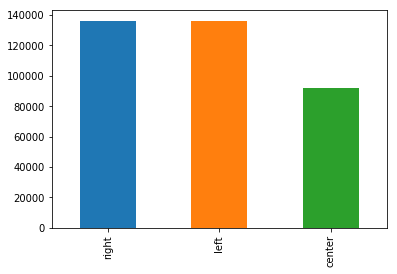

In [3]:
#checking class distribution
df['label_final'].value_counts().plot('bar')
#the corpus is heavily biased with left wing news

In [ ]:

#balancing classes by downsampling "left" news 
left = df[df["label_final"] == "left"]
other = df[df["label_final"] != "left"]

#code to ensure that the distribution of news sources is preserved while downsampling
div = []
for i in range(500):
    sample = left.sample(136305, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=left["doc_source"].value_counts(normalize = True).tolist())[0]
    div.append(p)
    if len(div) == 0:
        continue
    if p < min(div):
         break
lowest_div = min(div)

#code to ensure that the distribution of news sources is preserved while downsampling
for i in range(500):
    sample = left.sample(136305, random_state=i)
    p = chisquare(sample["doc_source"].value_counts(normalize = True).tolist(), f_exp=left["doc_source"].value_counts(normalize = True).tolist())[0]
    if p <= lowest_div:
        break


In [18]:
final_df = pd.concat([sample,other], axis = 0)

In [6]:
df.columns

Index(['Unnamed: 0', 'doc_id', 'doc_source', 'doc_title', 'doc_content',
       'doc_date', 'doc_url', 'label', 'label_final', 'topic0', 'topic1',
       'topic2', 'topic3', 'polarity', 'subjectivity'],
      dtype='object')

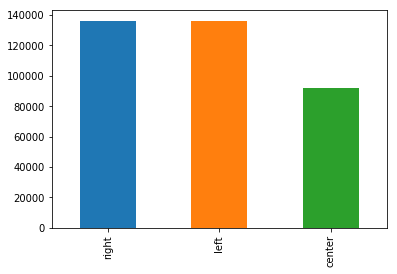

In [21]:
#lets check class distribution after downsampling
final_df['label_final'].value_counts().plot('bar')

In [24]:
final_df.to_csv("/Users/rakeshravi/Documents/Spring/Text Analytics/final_document.csv", index = False)

In [7]:
final_df = df
final_df.drop(["Unnamed: 0"], axis = 1, inplace = True)
final_df["doc_date"] = pd.to_datetime(final_df["doc_date"])

In [8]:
final_df['year'] = final_df['doc_date'].dt.year
final_df['month'] = final_df['doc_date'].dt.month

In [9]:
final_df['topic'] = final_df[['topic0','topic1','topic2', 'topic3']].idxmax(1).str.replace('topic','')
final_df["topic"] = final_df["topic"].astype('int')

In [10]:
for index, row in final_df.iterrows():
    if row["topic"] == 0:        
        if row["topic0"] < 0.00001:
            final_df.loc[index,"topic"] = 1

In [11]:
#reducing cardinality of labels to 3
list_of_topic_id = [0,1,2,3]
list_of_labels = ['Politics', 'Others','Crimes & Accidents','Business & Technology']
dictionary = dict(zip(list_of_topic_id, list_of_labels))
final_df['topic_label']= final_df['topic'].map(dictionary)

In [12]:
final_df.to_csv("final.csv")

## 1. Year Level

Text(0.5,1,'Sentiment Over Years')

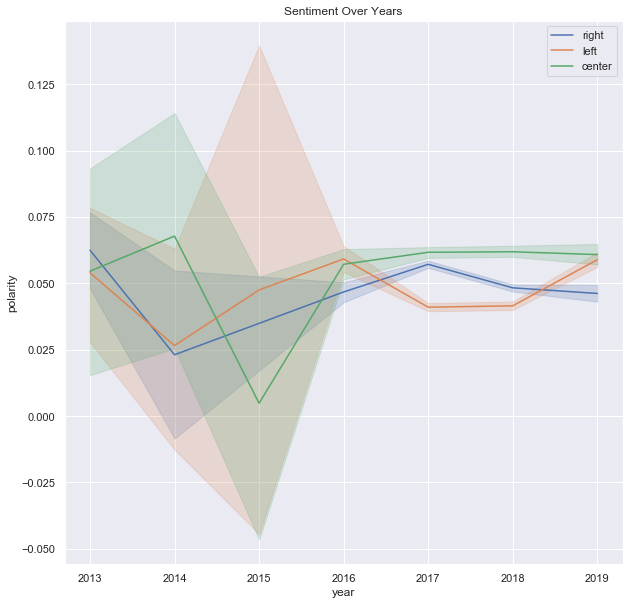

In [13]:
plt.figure(figsize=(10,10))
left = final_df[final_df["label_final"] == "left"]
right = final_df[final_df["label_final"] == "right"]
center = final_df[final_df["label_final"] == "center"]
sns.set(style='darkgrid')
sns.lineplot(x='year', y='polarity', data=right, label = "right")
sns.lineplot(x='year', y='polarity', data=left, label = "left")
sns.lineplot(x='year', y='polarity', data=center, label = "center")
plt.legend()
plt.title("Sentiment Over Years")

## 2. Month Level

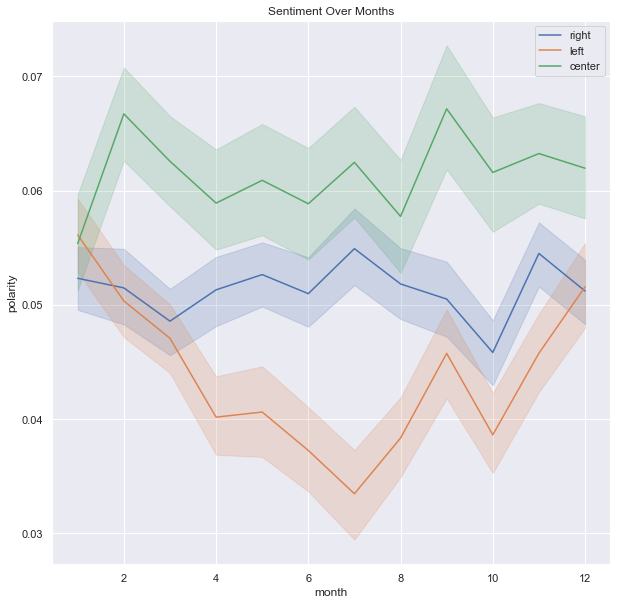

In [14]:
plt.figure(figsize=(10,10))
left = final_df[final_df["label_final"] == "left"]
right = final_df[final_df["label_final"] == "right"]
center = final_df[final_df["label_final"] == "center"]
sns.set(style='darkgrid')
sns.lineplot(x='month', y='polarity', data=right, label = "right")
sns.lineplot(x='month', y='polarity', data=left, label = "left")
sns.lineplot(x='month', y='polarity', data=center, label = "center")
plt.title("Sentiment Over Months")
plt.legend()

## 3. Topic Distribution

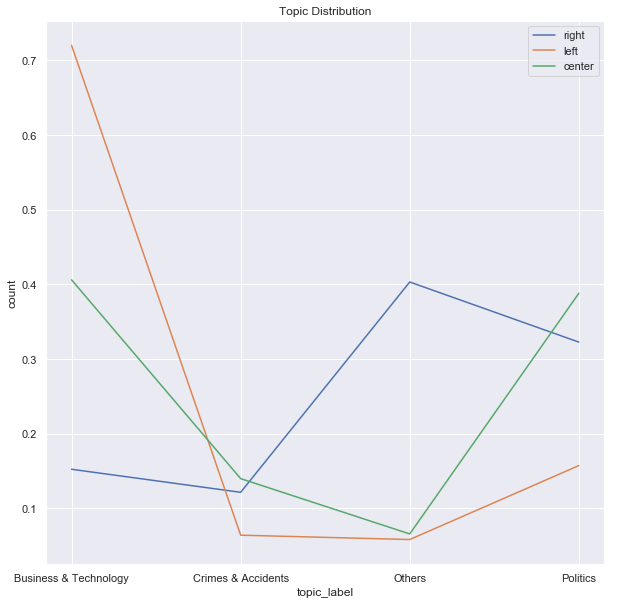

In [15]:
plt.figure(figsize=(10,10))
left = final_df[final_df["label_final"] == "left"]
right = final_df[final_df["label_final"] == "right"]
center = final_df[final_df["label_final"] == "center"]
left = pd.DataFrame(left.groupby(["topic_label"]).size()).reset_index()
right = pd.DataFrame(right.groupby(["topic_label"]).size()).reset_index()
center = pd.DataFrame(center.groupby(["topic_label"]).size()).reset_index()
left.columns = ["topic_label","count"]
right.columns = ["topic_label","count"]
center.columns = ["topic_label","count"]
left["count"] = left["count"]/left["count"].sum()
right["count"] = right["count"]/right["count"].sum()
center["count"] = center["count"]/center["count"].sum()
sns.set(style='darkgrid')
sns.lineplot(x='topic_label', y='count', data=right, label = 'right')
sns.lineplot(x='topic_label', y='count', data=left, label = 'left')
sns.lineplot(x='topic_label', y='count', data=center, label = 'center')
plt.title("Topic Distribution")
plt.legend()

## 4. Topic Distribution

In [16]:
final_df.dropna(inplace = True)
final_df["year"] = final_df["year"].astype('int')
df_plot = final_df[final_df["year"].isin([2016,2017,2018])]

In [25]:
def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()
    agg = { key : [ len(df[(df[rows]==value) & (df[columns]==key)]) for value in row_keys]
               for key in column_keys }
    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)
    ind = 0
    for index,row in aggdf.iterrows():
        for i in aggdf.columns:
            aggdf.loc[index,i] = row[i]/aggdf.sum(axis = 1).tolist()[ind]
        ind = ind + 1
    return aggdf.plot(kind='bar',stacked=True, figsize=(10,10))

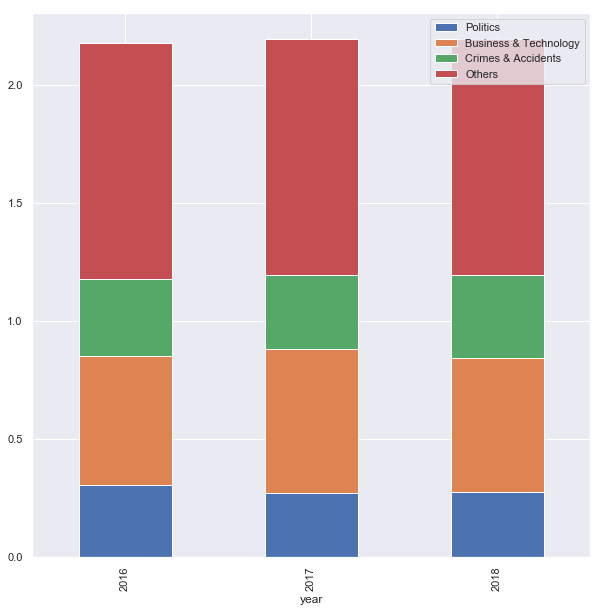

In [26]:
aggregate('year','topic_label',df_plot)

## 4. Mentions of Trump in Document Text

In [19]:
#function to count to plot occurences of someone or something
def count_plot_occurence(df, word, k, ye):
        if k == "year":
            for index,row in df.iterrows():
                if word in row["doc_content"]:
                    df.loc[index,"count"] = 1
                else:
                    df.loc[index,"count"] = 0
            left = df[df["label_final"] == "left"]
            right = df[df["label_final"] == "right"]
            center = df[df["label_final"] == "center"]
            left = pd.DataFrame(left.groupby(["year"]).agg({'count':'sum'})).reset_index()
            right = pd.DataFrame(right.groupby(["year"]).agg({'count':'sum'})).reset_index()
            center = pd.DataFrame(center.groupby(["year"]).agg({'count':'sum'})).reset_index()
            left["count"] = left["count"]/left["count"].sum()
            right["count"] = right["count"]/right["count"].sum()
            center["count"] = center["count"]/center["count"].sum()
            plt.figure(figsize=(10,10))
            sns.set(style='darkgrid')
            sns.lineplot(x='year', y='count', data=right, label = 'right')
            sns.lineplot(x='year', y='count', data=left, label = 'left')
            sns.lineplot(x='year', y='count', data=center, label = 'center')
            plt.title("word by year")    
        if k == "month":
            df = df[df["year"] == ye]
            plt.figure(figsize=(10,10))
            left = df[df["label_final"] == "left"]
            right = df[df["label_final"] == "right"]
            center = df[df["label_final"] == "center"]
            left = pd.DataFrame(left.groupby(["month"]).agg({'count':'sum'})).reset_index()
            right = pd.DataFrame(right.groupby(["month"]).agg({'count':'sum'})).reset_index()
            center = pd.DataFrame(center.groupby(["month"]).agg({'count':'sum'})).reset_index()
            left["count"] = left["count"]/left["count"].sum()
            right["count"] = right["count"]/right["count"].sum()
            center["count"] = center["count"]/center["count"].sum()
            sns.set(style='darkgrid')
            sns.lineplot(x='month', y='count', data=right, label = 'right')
            sns.lineplot(x='month', y='count', data=left, label = 'left')
            sns.lineplot(x='month', y='count', data=center, label = 'center')
            plt.title("word by year")

In [51]:
    #function to count to plot occurences of someone or something
    def monthyear_plot_occurence(df, word):
            df['m_date'] = pd.to_datetime(df['doc_date'], format='%m-%Y').dt.strftime('%m-%Y')
            for index,row in df.iterrows():
                if word in row["doc_content"]:
                    df.loc[index,"count"] = 1
                else:
                    df.loc[index,"count"] = 0
            left = df[df["label_final"] == "left"]
            right = df[df["label_final"] == "right"]
            center = df[df["label_final"] == "center"]
            left = pd.DataFrame(left.groupby(["m_date"]).agg({'count':'sum'})).reset_index()
            right = pd.DataFrame(right.groupby(["m_date"]).agg({'count':'sum'})).reset_index()
            center = pd.DataFrame(center.groupby(["m_date"]).agg({'count':'sum'})).reset_index()
            left["m_date"] = pd.to_datetime(left["m_date"])
            right["m_date"] = pd.to_datetime(right["m_date"])
            center["m_date"] = pd.to_datetime(center["m_date"])
            left["count"] = left["count"]/left["count"].sum()
            right["count"] = right["count"]/right["count"].sum()
            center["count"] = center["count"]/center["count"].sum()
            plt.figure(figsize=(30,30))
            sns.set(style='darkgrid')
            sns.lineplot(x='m_date', y='count', data=right, label = 'right')
            sns.lineplot(x='m_date', y='count', data=left, label = 'left')
            sns.lineplot(x='m_date', y='count', data=center, label = 'center')
            plt.title("word by year")    
            

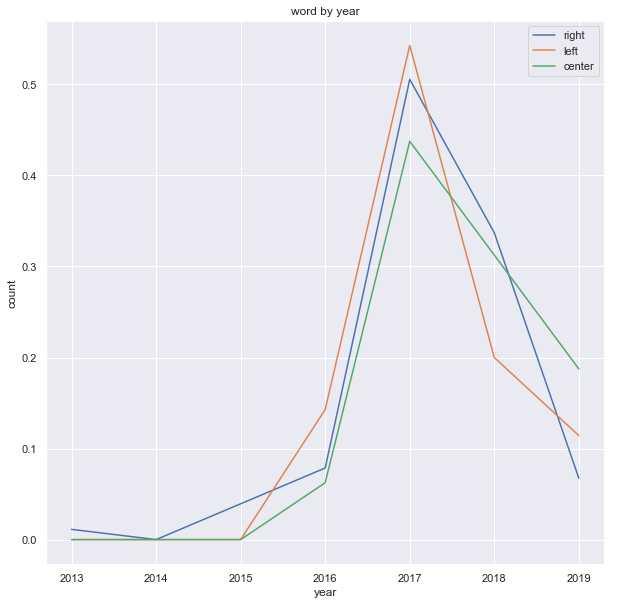

In [20]:
count_plot_occurence(final_df,"trump","year",2017)

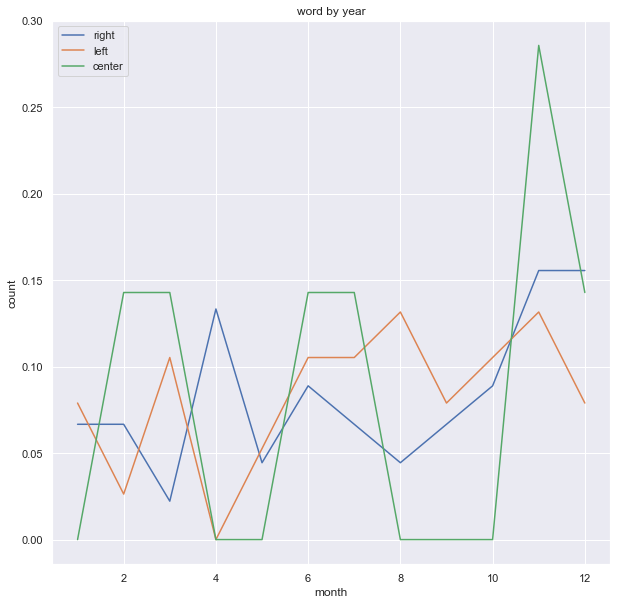

In [21]:
count_plot_occurence(final_df,"trump","month",2017)

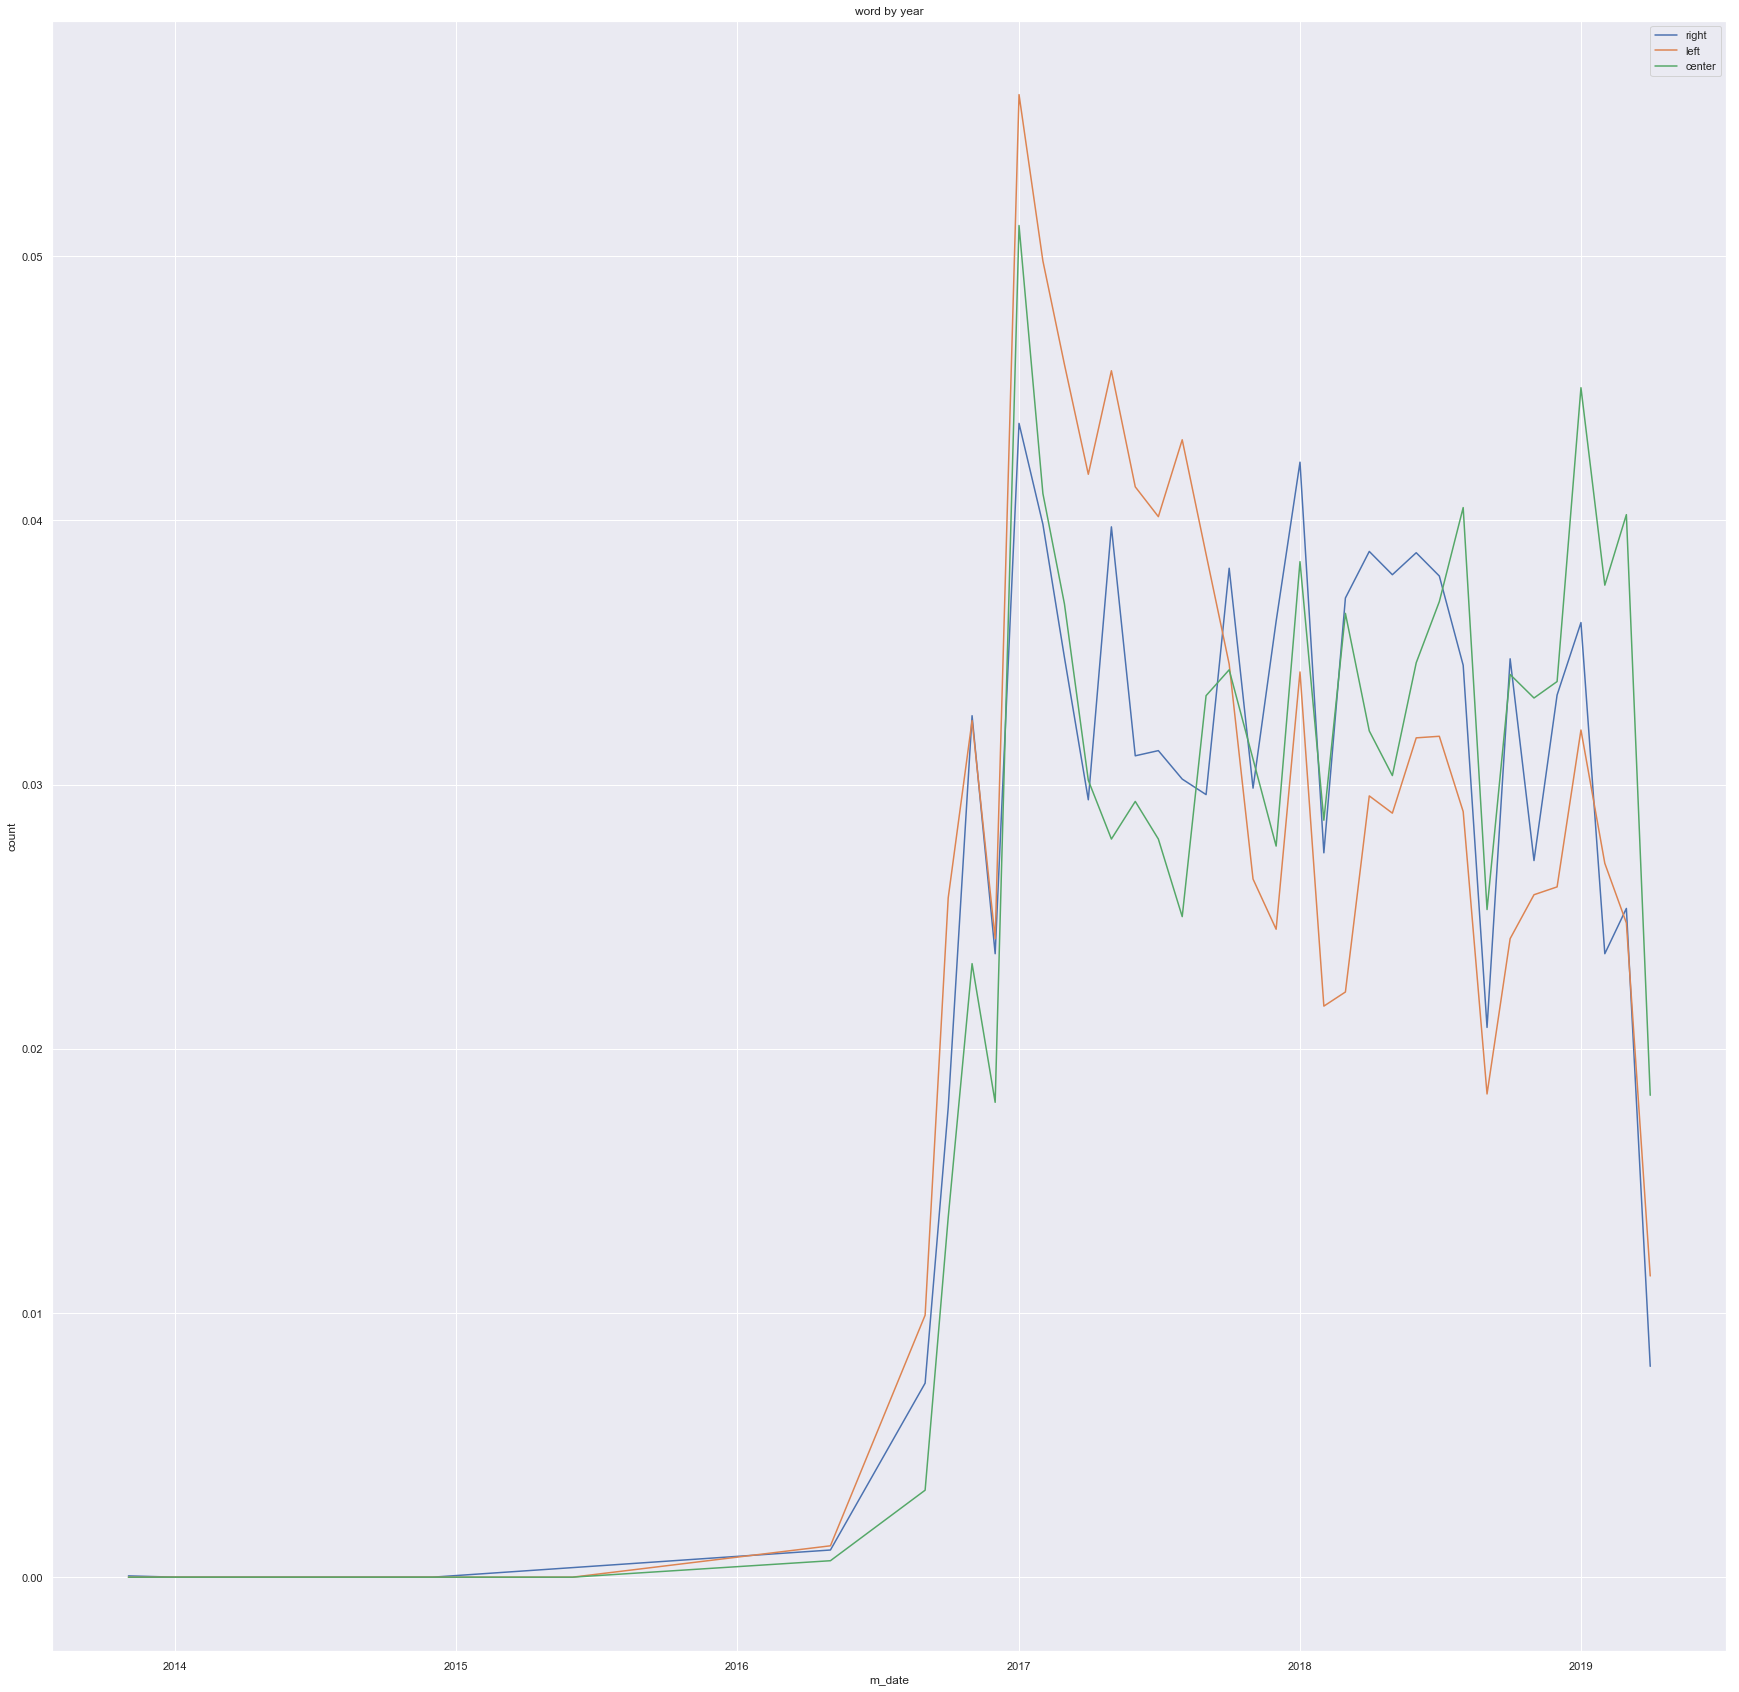

In [53]:
monthyear_plot_occurence(final_df, "Trump")

## 5. Mentions of ISIS in Document Text

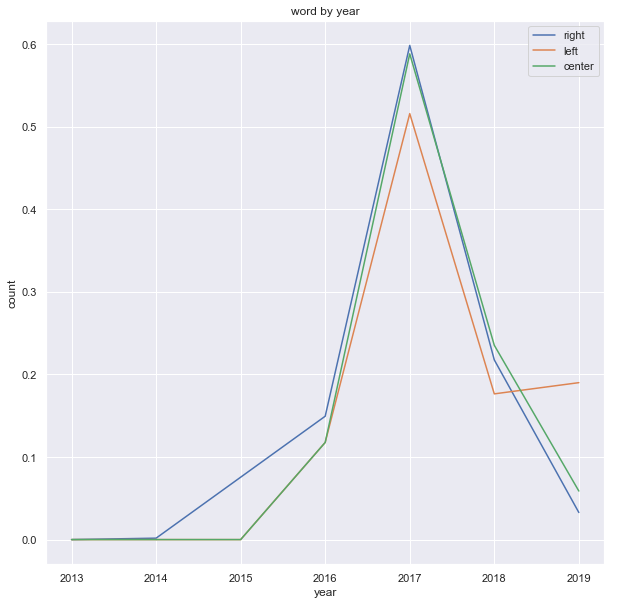

In [22]:
count_plot_occurence(final_df,"ISIS","year",2017)

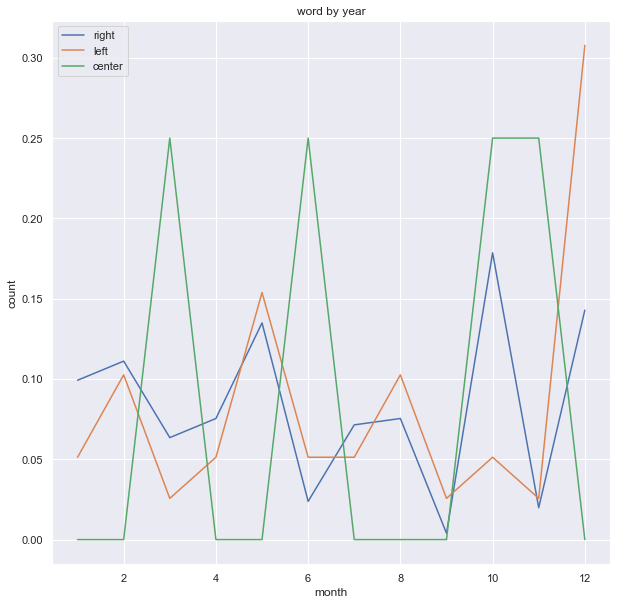

In [24]:
count_plot_occurence(final_df,"ISIS","month",2018)

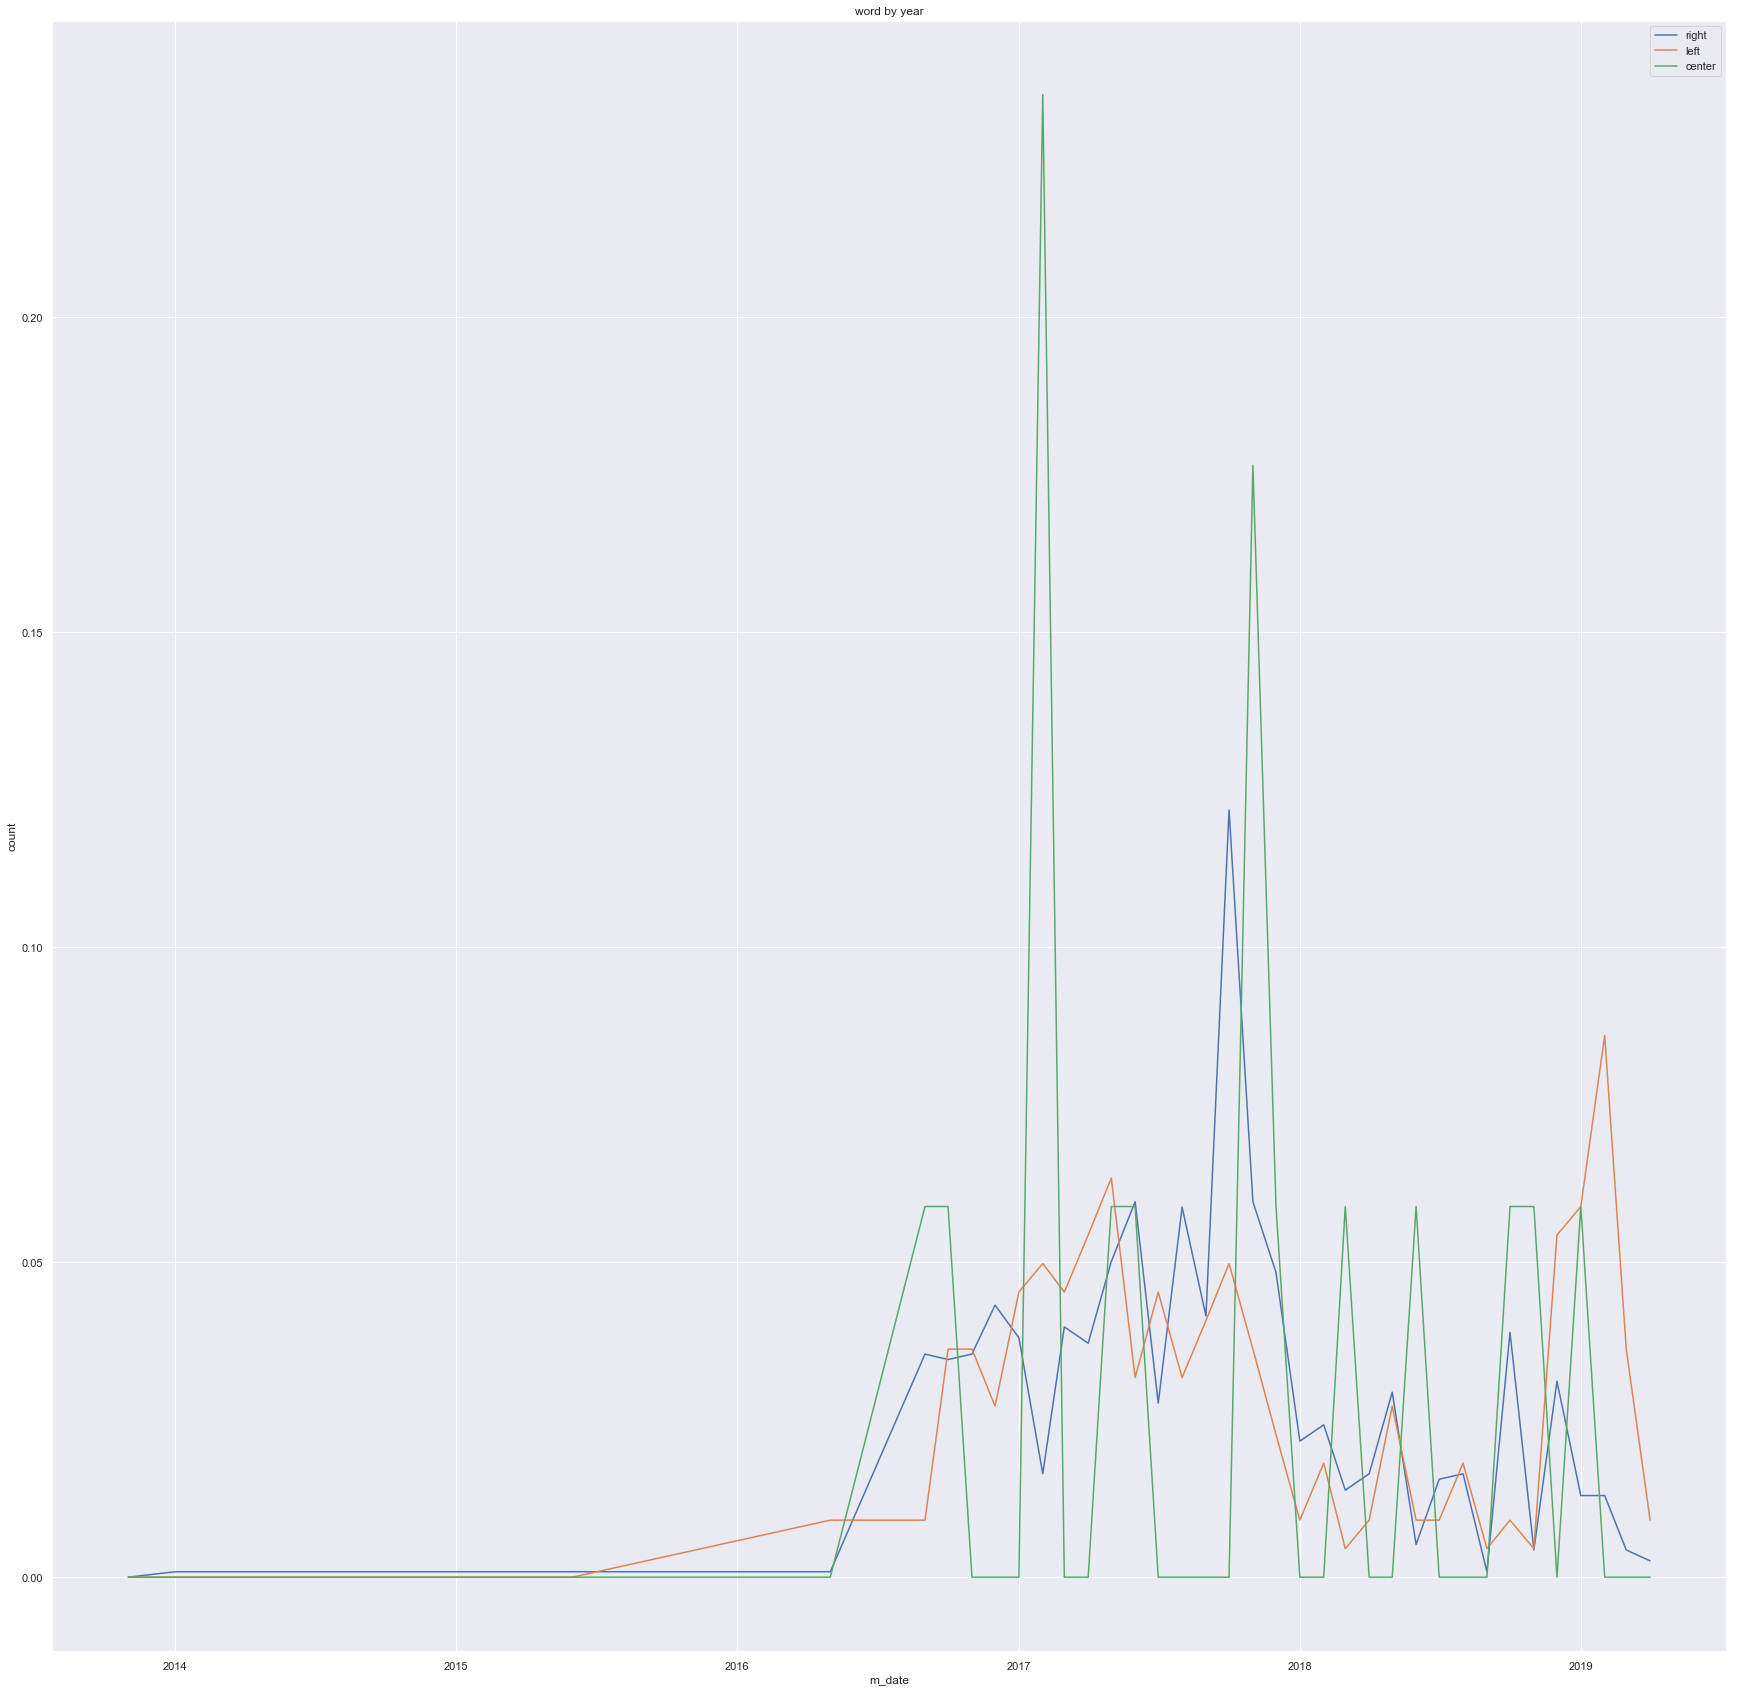

In [52]:
monthyear_plot_occurence(final_df, "ISIS")